In [1]:
%autoreload 2


In [2]:
from argparse import Namespace
from collections import defaultdict
import copy
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src import ast_printer

2023-08-30 15:49:18 - ast_utils - DEBUG    - Using cache folder: /misc/vlgscratch4/LakeGroup/guy/game_generation_cache
2023-08-30 15:49:18 - src.ast_utils - DEBUG    - Using cache folder: /misc/vlgscratch4/LakeGroup/guy/game_generation_cache


In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
regrown_game_1024_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl.gz'))
print(len(real_game_texts), len(regrown_game_1024_texts), len(regrown_game_1024_texts) / 98)


2023-08-30 15:49:20 - src.ast_utils - INFO     - Loading from cache file: /misc/vlgscratch4/LakeGroup/guy/game_generation_cache/interactive-beta-cache.pkl.gz
2023-08-30 15:49:20 - src.ast_utils - INFO     - Finished loading cache file: /misc/vlgscratch4/LakeGroup/guy/game_generation_cache/interactive-beta-cache.pkl.gz


98 100352 1024.0


In [4]:
def extract_game_index(game_name: str):
    first_dash = game_name.find('-')
    second_dash = game_name.find('-', first_dash + 1)
    index = game_name[first_dash + 1:second_dash] if second_dash != -1 else game_name[first_dash + 1:]
    return int(index)


def extract_negative_index(game_name: str):
    first_dash = game_name.find('-')
    second_dash = game_name.find('-', first_dash + 1)
    if second_dash == -1:
        return -1
    
    third_dash = game_name.find('-', second_dash + 1)
    index = game_name[second_dash + 1:third_dash]
    return int(index)


fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')

# fitness_df = fitness_df.assign(real=fitness_df.real.astype('int'), game_index=fitness_df.game_name.apply(extract_game_index), 
#                                negative_index= fitness_df.game_name.apply(extract_negative_index), fake=~fitness_df.real.astype('int'))
# fitness_df = fitness_df.sort_values(by=['fake', 'game_index', 'negative_index'], ignore_index=True).reset_index(drop=True)
# fitness_df.drop(columns=['Index', 'fake', 'game_index', 'negative_index'], inplace=True)
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl.gz']


,Index,src_file,game_name,domain_name,original_game_name,real,variables_defined_all,variables_defined_incorrect_count,variables_used_all,variables_used_incorrect_count,...,ast_ngram_constraints_n_4_score,ast_ngram_constraints_n_5_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,0.0,1,0.0,...,0.968605,0.979319,0.964286,0.973077,0.976571,0.978192,0.919430,0.960971,0.998704,1.000000
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,0.0,1,0.0,...,0.974280,0.978391,0.959478,0.966184,0.977509,0.978958,0.899454,0.915154,0.965182,0.973559
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,0.0,1,0.0,...,0.946566,0.972470,0.000000,0.000000,0.000000,0.000000,0.851207,0.904668,0.948186,0.955972
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,0.0,1,0.0,...,0.986871,0.980256,0.000000,0.000000,0.000000,0.000000,0.919430,0.960971,0.998704,1.000000
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,0.0,1,0.0,...,0.983288,0.979510,0.000000,0.000000,0.000000,0.000000,0.964678,0.971974,0.973129,0.963587


In [5]:
# USE_BINARIZED_FEATURES_MODEL = True

# if USE_BINARIZED_FEATURES_MODEL:
#     model_path = '../models/cv_binarized_model_2023_01_20.pkl.gz'
#     data_df = binarized_df
# else:
#     model_path = '../models/cv_fitness_model_2023_01_20.pkl.gz'
#     data_df = filtered_fitness_df
from latest_model_paths import LATEST_FITNESS_FUNCTION_DATE_ID, LATEST_SPECIFIC_OBJECTS_FITNESS_FUNCTION_DATE_ID
# model_date_id = LATEST_FITNESS_FUNCTION_DATE_ID
# model_date_id = LATEST_SPECIFIC_OBJECTS_FITNESS_FUNCTION_DATE_ID
model_date_id = 'full_features_no_in_data_all_2023_08_28'
data_df = fitness_df
cv_energy_model, feature_columns = utils.load_model_and_feature_columns(model_date_id)
print(len(feature_columns))



353


In [6]:
full_tensor = utils.df_to_tensor(data_df, feature_columns)
if 'wrapper' in cv_energy_model.named_steps: cv_energy_model.named_steps['wrapper'].eval()
full_tensor_scores = cv_energy_model.transform(full_tensor).detach()

In [7]:
real_game_scores = full_tensor_scores[:, 0]

print(f'Real game scores: {real_game_scores.mean():.4f} ± {real_game_scores.std():.4f}, min = {real_game_scores.min():.4f}, max = {real_game_scores.max():.4f}')

negatives_scores = full_tensor_scores[:, 1:]
torch.quantile(negatives_scores.ravel(), torch.linspace(0, 1, 11))
print(f'20th percentile negative energy: {torch.quantile(negatives_scores.ravel(), 0.2)}')

Real game scores: -20.6543 ± 0.4613, min = -21.7223, max = -19.1381
20th percentile negative energy: -19.25890350341797


In [8]:
steps = torch.linspace(0, 1, 11)
deciles = torch.quantile(negatives_scores.ravel(), steps)
print(steps)
print(f'Energy deciles: {deciles}')

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])
Energy deciles: tensor([-23.2239, -20.3288, -19.2589, -17.9164, -16.7815, -16.0669, -15.1895,
        -14.0332, -12.6711,  -9.9888,  21.7660])


Weights mean: 0.1440, std: 0.8256, bias: 0.0100


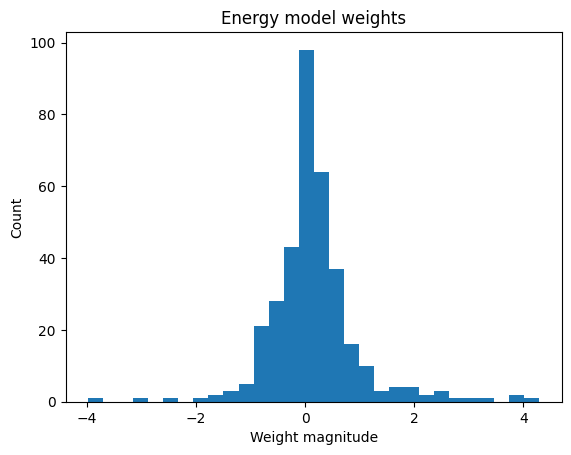

In [9]:
weights = cv_energy_model.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()  # type: ignore
bias = cv_energy_model.named_steps['fitness'].model.fc1.bias.data.detach().squeeze()  # type: ignore
print(f'Weights mean: {weights.mean():.4f}, std: {weights.std():.4f}, bias: {bias:.4f}')

plt.hist(weights, bins=30)
plt.title('Energy model weights')
plt.xlabel('Weight magnitude')
plt.ylabel('Count')
plt.show()

In [10]:
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
quantile_index = 0

abs_weights = weights.abs()

for magnitude in torch.linspace(0,abs_weights.max(), 5000):
    n = torch.sum(abs_weights < magnitude).item()
    if n / len(weights) >= quantiles[quantile_index]:
        print(f'Approximately {quantiles[quantile_index] * 100}% ({n}, {n / len(weights) * 100:.2f}%) of the weights have magnitude < {magnitude:.4f}')
        quantile_index += 1

    if quantile_index >= len(quantiles):
        break

Approximately 10.0% (37, 10.48%) of the weights have magnitude < 0.0514
Approximately 25.0% (89, 25.21%) of the weights have magnitude < 0.1226
Approximately 50.0% (177, 50.14%) of the weights have magnitude < 0.3147
Approximately 75.0% (265, 75.07%) of the weights have magnitude < 0.6783
Approximately 90.0% (318, 90.08%) of the weights have magnitude < 1.1276
Approximately 95.0% (336, 95.18%) of the weights have magnitude < 1.8307
Approximately 99.0% (350, 99.15%) of the weights have magnitude < 3.7866


In [11]:
from src.fitness_features_by_category import FEATURE_CATEGORIES


def print_weights_summary_by_category(model_weights: torch.Tensor, all_feature_columns: typing.List[str], return_lines: bool = False):
    abs_weights = model_weights.abs()
    sorted_feature_names = [t[1] for t in sorted([(abs_weights[i], all_feature_columns[i]) for i in range(len(all_feature_columns))], key=lambda x: x[0], reverse=True)]

    lines = []
    all_assigned_features = set()

    for category, features in FEATURE_CATEGORIES.items():
        category_feature_list = []
        for feature in features:
            if isinstance(feature, re.Pattern):
                category_feature_list.extend([f for f in feature_columns if feature.match(f)])

            else:
                category_feature_list.append(feature)

        all_assigned_features.update(category_feature_list)
        
        mean_abs_weight = np.mean([abs_weights[feature_columns.index(feature)] for feature in category_feature_list])
        sum_abs_weight = np.sum([abs_weights[feature_columns.index(feature)] for feature in category_feature_list])
        mean_sorted_index = np.mean([sorted_feature_names.index(feature) for feature in category_feature_list])
        prefix = f'For category {category} with {len(category_feature_list)} features'
        line = f'{prefix:54} | mean abs weight is {mean_abs_weight:5.2f} | sum abs weight is {sum_abs_weight:6.2f} | mean sorted index is {mean_sorted_index:6.2f}'
        if return_lines:
            lines.append(line)
        else:
            print(line)

    unassigned_features = [f for f in feature_columns if f not in all_assigned_features]
    if len(unassigned_features) > 0:
        print(f'Unassigned features: {unassigned_features}')

    if return_lines:
        return lines


In [13]:
l1_model, _ = utils.load_model_and_feature_columns('full_features_no_in_data_all_L1_2023_08_28')

In [14]:
MODEL_NAMES = ['Baseline', 'L1']
models = [cv_energy_model, l1_model]

for model_name, model in zip(MODEL_NAMES, models):
    display(Markdown(f'### For model {model_name}'))
    print_weights_summary_by_category(model.named_steps['fitness'].model.fc1.weight.data.detach().squeeze(), feature_columns)
    

### For model Baseline

For category grammar_context with 12 features          | mean abs weight is  1.21 | sum abs weight is  14.53 | mean sorted index is 125.00
For category ngram_and_data_based with 7 features      | mean abs weight is  1.27 | sum abs weight is   8.92 | mean sorted index is  70.57
For category counting with 101 features                | mean abs weight is  0.27 | sum abs weight is  26.91 | mean sorted index is 220.53
For category forall with 18 features                   | mean abs weight is  0.88 | sum abs weight is  15.93 | mean sorted index is 162.72
For category predicate_under_modal with 50 features    | mean abs weight is  0.37 | sum abs weight is  18.42 | mean sorted index is 193.70
For category predicate_role_filler with 138 features   | mean abs weight is  0.58 | sum abs weight is  80.19 | mean sorted index is 149.46
For category compositionality with 10 features         | mean abs weight is  0.06 | sum abs weight is   0.59 | mean sorted index is 311.40
For category grammar_use wi

### For model L1

For category grammar_context with 12 features          | mean abs weight is  0.63 | sum abs weight is   7.52 | mean sorted index is 181.25
For category ngram_and_data_based with 7 features      | mean abs weight is  0.31 | sum abs weight is   2.14 | mean sorted index is  96.43
For category counting with 101 features                | mean abs weight is  0.01 | sum abs weight is   1.51 | mean sorted index is 170.04
For category forall with 18 features                   | mean abs weight is  0.42 | sum abs weight is   7.55 | mean sorted index is 194.61
For category predicate_under_modal with 50 features    | mean abs weight is  0.02 | sum abs weight is   0.85 | mean sorted index is 210.34
For category predicate_role_filler with 138 features   | mean abs weight is  0.07 | sum abs weight is  10.20 | mean sorted index is 163.91
For category compositionality with 10 features         | mean abs weight is  0.00 | sum abs weight is   0.00 | mean sorted index is 314.30
For category grammar_use wi

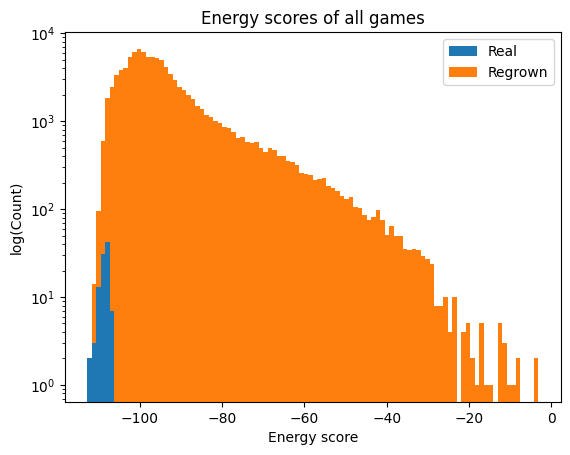

In [29]:
utils.plot_energy_histogram(cv_energy_model, full_tensor)

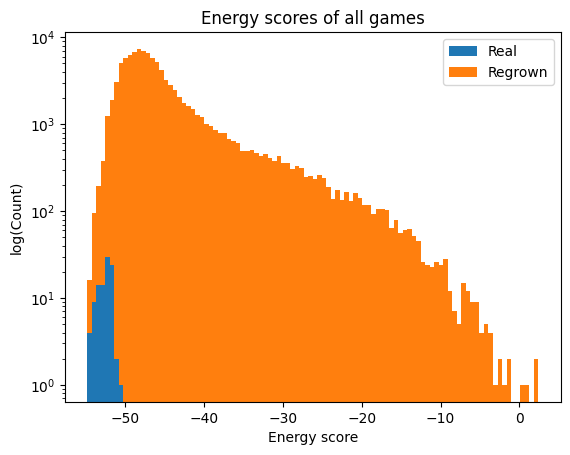

In [30]:
utils.plot_energy_histogram(l1_1e2_model, full_tensor)